In [1]:
import nltk
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from transformers import BitsAndBytesConfig
from functools import lru_cache


# 1. Reading the CSV File and Preparing Data

In [2]:
# provide project root path
ProjectRoot = ""
DatasetRoot = ProjectRoot + "manuals/"

# Load the manually curated CSV file
file_path = DatasetRoot + '/Fraggles_X700_2022_HCM_QA_Curated.csv'
df = pd.read_csv(file_path,  encoding='latin1')

#keep only one question per chunk
df.dropna(subset=['question', 'answer'], inplace=True)
df = df.drop_duplicates(subset=['para_id'], keep='first')
df = df.reset_index(drop=False)  # Adds the index as a new column
df =df.reset_index(drop=False)

# Check the first few rows to understand the structure
print(df.head())

   level_0  index  page_number  \
0        0      0            1   
1        1      3            1   
2        2      6            1   
3        3      9            1   
4        4     12            2   

                                             para_id  \
0  e6c45229dc996b6ba2ecb9ddb251f77c5ee3f2de93cc1d...   
1  69dedd5e3d5bbf7c8e9a12176d60789e110a65cd533d26...   
2  fc843f5ed9e92f0a42868ed7813e7c197902b5f2194f87...   
3  0c927bca6c80fe20d270cb43d62ea95099483181509007...   
4  560865acae00a7a1c7b35d8567b972195079a68eddcf40...   

                                      sentence_chunk  \
0  check that the rod is ï¬rmly placed to avoid ...   
1  If you feel any resistance, stop and  check fo...   
2  Pull the hood release handle: The hood release...   
3  The support rod is typically located  on the u...   
4  Genuine FragglesX700HCM Motor Oil (for optimal...   

                                            question  \
0  What should you do to prevent the hood from ac...   
1  What s

# 2. Evaluate Model Responses Using BLEU and ROUGE

In [3]:
# Download NLTK data for BLEU
nltk.download('punkt')

def evaluate_bleu(reference: str, candidate: str) -> float:
    reference_tokens = nltk.word_tokenize(reference.lower())
    candidate_tokens = nltk.word_tokenize(candidate.lower())
    return sentence_bleu([reference_tokens], candidate_tokens)

def evaluate_rouge(reference: str, candidate: str) -> dict:
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores


[nltk_data] Downloading package punkt to /home/vinoj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 3. Generate Responses from Different LLMs

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from sentence_transformers import SentenceTransformer
import chromadb

# Generalized model loading function
@lru_cache(maxsize=5)
def load_model(model_id='meta-llama/Llama-2-7b-chat-hf', use_quantization=True):
    from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, AutoConfig
    import torch
    
    if use_quantization:
        quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)
    else:
        quantization_config = None  # Skip quantization
    
    # Flash Attention Check (Simplified: Just use 'sdpa' for now)
    attn_implementation = "sdpa"  # You can adjust this depending on your hardware or preference
    
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    config = AutoConfig.from_pretrained(model_id)
    config.hidden_activation = "gelu"
    
    llm_model = AutoModelForCausalLM.from_pretrained(model_id, config=config,
                                                     torch_dtype=torch.float16,
                                                     quantization_config=quantization_config,
                                                     low_cpu_mem_usage=True,
                                                     attn_implementation=attn_implementation)

    if not use_quantization:
        llm_model.to("cuda")
    
    return tokenizer, llm_model

# Format Prompt - Used to augment query with context
def prompt_formatter(query: str, context_items: list[str]):
    """
    Format the prompt by adding context and creating an ideal answer format.
    """
    # Join context items into a single string
    context = "- " + "\n- ".join(context_items)

    base_prompt = """Using the following context items, please answer the user query directly.
                    Extract and incorporate relevant information from the context, but do not mention the context or how you arrived at your answer.
                    Provide a clear, concise, and explanatory answer.
                    Use the following examples as a reference for the ideal answer style.

                    Example:
                    Query: What are the signs that your car needs an oil change?
                    Answer: The signs that your car needs an oil change include a warning light on the dashboard, dark and gritty oil, unusual engine noises, decreased fuel efficiency, and a burnt smell from the engine. Regularly checking the oil level and its condition can help determine the right time for an oil change, typically every 5,000 to 7,500 miles.

                    Now use the following context items to answer the user query:
                    {context}
                    User query: {query}
                    Answer:
                """

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user", "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt

# ChromaDB Searcher class
class ChromaDBSearcher:
    def __init__(self, chroma_db_dir="chroma_db_dir", model_name="all-mpnet-base-v2"):
        """
        Initializes a ChromaDB searcher with a given directory and embedding model.
        """
        self.client = chromadb.PersistentClient(path=chroma_db_dir)
        self.collection = self.client.get_collection("pdf_chunks")
        self.model = SentenceTransformer(model_name)

    def search_by_id(self, document_source, query):
        """
        Perform a search by ID using query embedding to find relevant context.
        """
        query_embedding = self.model.encode(query, convert_to_tensor=True).cpu().numpy()
        results = self.collection.query(
            query_embedding.tolist(),
            where={"source": document_source},
            n_results=10
        )
        if results and results['documents']:
            # Ensure that the documents returned are strings, not lists
            return [doc if isinstance(doc, str) else str(doc) for doc in results['documents']]
        return []

searcher = ChromaDBSearcher()
# Ask function - Takes query, context, and model to generate the response
def ask(document_source, query, tokenizer, llm_model, temperature=0.5, max_new_tokens=512, format_answer_text=True, return_answer_only=True):
    """
    Takes a query, finds relevant resources/context, and generates an answer to the query based on the relevant resources.
    """
  
    # Retrieve context items for the query
    context_items = searcher.search_by_id(document_source, query)

    # Format the prompt with context items
    prompt = prompt_formatter(query=query, context_items=context_items)

    # Ensure that prompt is a string or list of strings
    if not isinstance(prompt, str):
        print(query, prompt)
        raise ValueError(f"Expected prompt to be a string, got {type(prompt)}")



    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Convert the output tokens back to text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Clean up the output text (e.g., remove special tokens)
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Return only the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items


# 4. Evaluate Each Question-Answer Pair for Multiple Models

In [5]:
def get_model_id(model_name):
    if model_name == "Llama-2":
        return "meta-llama/Llama-2-7b-chat-hf"  
    elif model_name == "gemma-2":
        return "google/gemma-2b-it"  
    elif model_name == "GPT-2":
        return "openai-community/gpt2-medium"  
    else:
        raise ValueError(f"Unknown model name: {model_name}")


# Create an empty list to store the evaluation results
evaluation_results = []
models = ["Llama-2", "gemma-2"]

# Loop through the chunks in the dataframe (assuming each chunk is already grouped)
for chunk_index, chunk in enumerate(df.groupby('para_id')):  # Assuming 'para_id' is the identifier
    chunk_data = chunk[1]  # Get the actual chunk
    
    # Process each question-answer pair in the chunk
    for index, row in chunk_data.iterrows():
        question = row['question']
        reference_answer = row['answer']
        
        # Loop through each model to generate answers
        for model_name in models:
            # Load the model and tokenizer dynamically for each model
            model_id = get_model_id(model_name)  # Assuming you have a function to map model names to IDs
            tokenizer, llm_model = load_model(model_id)
            
            # Generate answer using the `ask` function
            generated_answer = ask("document_source", question, tokenizer, llm_model)
            
            # Evaluate BLEU score
            bleu_score = evaluate_bleu(reference_answer, generated_answer)
            
            # Evaluate ROUGE score
            rouge_scores = evaluate_rouge(reference_answer, generated_answer)
            
            # Append the results for this chunk, question, and model
            print(f"Model: {model_name}")
            print(f"Chunk: {chunk_index}")
            print(f"Question: {question}")
            print(f"BLEU Score: {bleu_score:.4f}")
            print(f"ROUGE-1: {rouge_scores['rouge1'].fmeasure:.4f}")
            print(f"ROUGE-2: {rouge_scores['rouge2'].fmeasure:.4f}")
            print(f"ROUGE-L: {rouge_scores['rougeL'].fmeasure:.4f}")

            evaluation_results.append({
                "Model": model_name,
                "Chunk": chunk_index,
                "Question": question,
                "BLEU": bleu_score,
                "ROUGE-1": rouge_scores['rouge1'].fmeasure,
                "ROUGE-2": rouge_scores['rouge2'].fmeasure,
                "ROUGE-L": rouge_scores['rougeL'].fmeasure
            })

# Convert evaluation results into a DataFrame
eval_df = pd.DataFrame(evaluation_results)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model: Llama-2
Chunk: 0
Question: Where is the support rod typically located in most vehicles?
BLEU Score: 0.0232
ROUGE-1: 0.1197
ROUGE-2: 0.0851
ROUGE-L: 0.1056


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: gemma-2
Chunk: 0
Question: Where is the support rod typically located in most vehicles?
BLEU Score: 0.0000
ROUGE-1: 0.3478
ROUGE-2: 0.1364
ROUGE-L: 0.2174
Model: Llama-2
Chunk: 1
Question: What is the first step in replacing a side marker light bulb?  
BLEU Score: 0.0000
ROUGE-1: 0.1041
ROUGE-2: 0.0300
ROUGE-L: 0.0743
Model: gemma-2
Chunk: 1
Question: What is the first step in replacing a side marker light bulb?  
BLEU Score: 0.0000
ROUGE-1: 0.2449
ROUGE-2: 0.0851
ROUGE-L: 0.1633
Model: Llama-2
Chunk: 2
Question: What precautions should you take when jump-starting a vehicle with a damaged or cracked battery?  
BLEU Score: 0.0247
ROUGE-1: 0.1268
ROUGE-2: 0.0618
ROUGE-L: 0.1014
Model: gemma-2
Chunk: 2
Question: What precautions should you take when jump-starting a vehicle with a damaged or cracked battery?  
BLEU Score: 0.0929
ROUGE-1: 0.3733
ROUGE-2: 0.1644
ROUGE-L: 0.2933
Model: Llama-2
Chunk: 3
Question: What is the typical oil change capacity, including the filter?
BLEU Score:

/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/sw/pkgs/arc/python3.11-anaconda/2024.02-1/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: gemma-2
Chunk: 6
Question: How should corrosion on battery terminals be cleaned?  
BLEU Score: 0.0000
ROUGE-1: 0.2373
ROUGE-2: 0.0000
ROUGE-L: 0.1017
Model: Llama-2
Chunk: 7
Question: Why should you avoid using tools to excessively tighten the oil filter?
BLEU Score: 0.0000
ROUGE-1: 0.1135
ROUGE-2: 0.0571
ROUGE-L: 0.0780
Model: gemma-2
Chunk: 7
Question: Why should you avoid using tools to excessively tighten the oil filter?
BLEU Score: 0.0000
ROUGE-1: 0.2449
ROUGE-2: 0.1277
ROUGE-L: 0.2041
Model: Llama-2
Chunk: 8
Question: What type of coolant should be used for the engine?
BLEU Score: 0.0000
ROUGE-1: 0.0447
ROUGE-2: 0.0000
ROUGE-L: 0.0335
Model: gemma-2
Chunk: 8
Question: What type of coolant should be used for the engine?
BLEU Score: 0.0000
ROUGE-1: 0.2174
ROUGE-2: 0.0000
ROUGE-L: 0.1304
Model: Llama-2
Chunk: 9
Question: What is the recommended interval for tire rotation?  
BLEU Score: 0.0167
ROUGE-1: 0.1250
ROUGE-2: 0.0630
ROUGE-L: 0.1094
Model: gemma-2
Chunk: 9
Question: Wh

NameError: name 'np' is not defined

# 5. Plotting the Evaluation Results

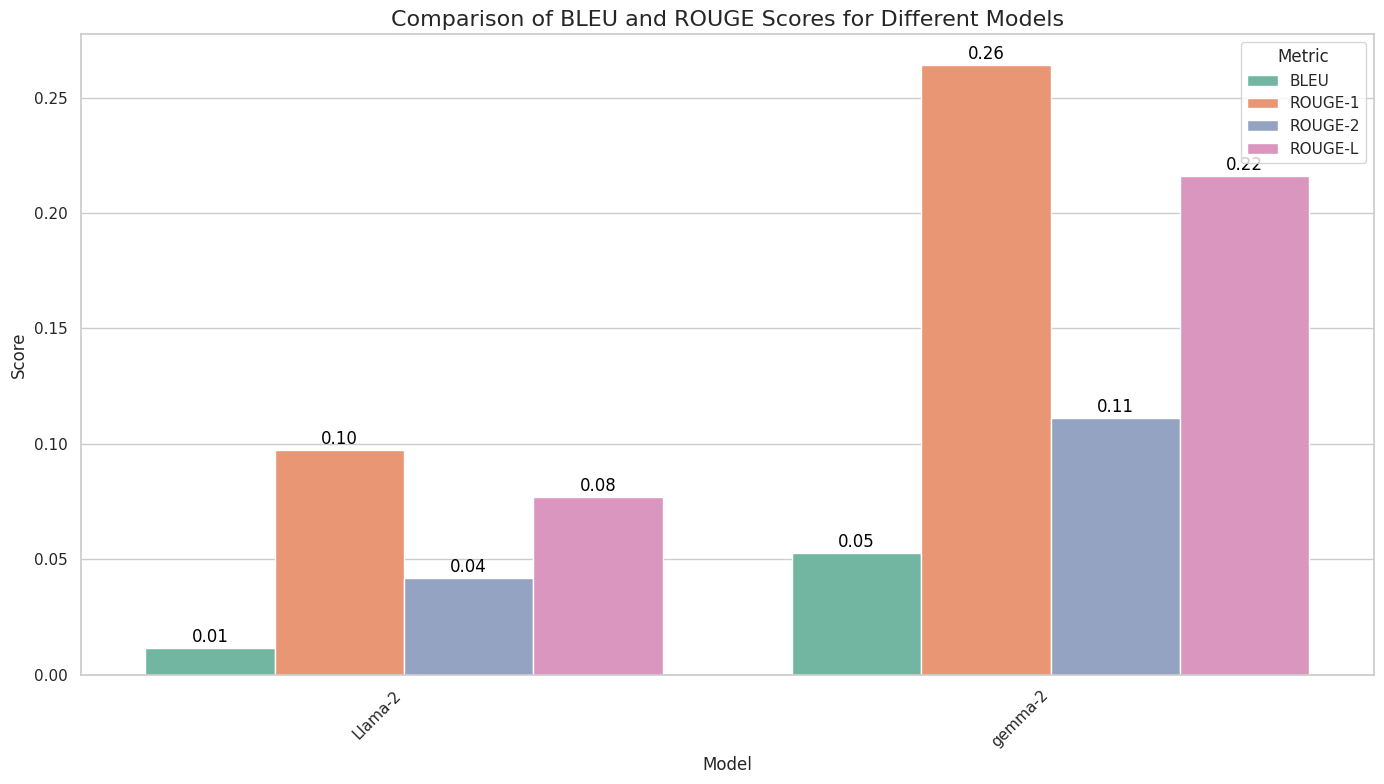

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reshaping the data into a long format
melted_scores = average_scores.melt(id_vars="Model", 
                                    value_vars=["BLEU", "ROUGE-1", "ROUGE-2", "ROUGE-L"],
                                    var_name="Metric", 
                                    value_name="Score")

# Set the plotting style
sns.set(style="whitegrid")

# Create the grouped bar chart
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="Model", y="Score", hue="Metric", data=melted_scores, palette="Set2")

# Title and labels
plt.title("Comparison of BLEU and ROUGE Scores for Different Models", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add annotations for each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black',
                xytext=(0, 8), textcoords='offset points')

# Display the plot
plt.legend(title="Metric", loc="upper right")
plt.tight_layout()
plt.show()
